In [1]:
!nvidia-smi

Sat Dec 20 18:13:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:1A:00.0 Off |                    0 |
| N/A   29C    P0             42W /  300W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import pyvista as pv
import matplotlib.pyplot as p
from matplotlib.colors import LinearSegmentedColormap,ListedColormap, BoundaryNorm
import matplotlib.cm as cm
from pathlib import PureWindowsPath
import re
from pathlib import Path
import pickle

import cedalion
import cedalion.dot as dot
import cedalion.dataclasses as cdc
import cedalion.sigproc.quality as quality
import cedalion.sigproc.physio as physio
import cedalion.nirs as nirs
import cedalion.geometry.landmarks
from cedalion import units
from cedalion.io.forward_model import load_Adot
from cedalion.io import read_events_from_tsv
import cedalion.sigproc.motion as motion_correct

pv.set_jupyter_backend("html")

%load_ext autoreload
%autoreload 2
%matplotlib widget

os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/orabe/fNIRS_sparseToDense'

In [3]:
def standardize_trial_types(DATASET_NAME: str, file: str, stim: pd.DataFrame, rec):
    
    if DATASET_NAME == "FreshMotor":
        # map trial types to left or right depending on the name of the file
        m = re.search(r'(?i)(left|right)', file)

        # rename from MOTOR to left/right
        stim.trial_type = m.group(1).lower()
        rec.stim = stim
    
    else:
        mapping = {
            "Right": "right", # BallSqueezingHD
            "Left": "left",   # BallSqueezingHD
            "ElectricalVAS7": "right", # TODO: Electrical_Thermal
            "ElectricalVAS3": "left",  # TODO: Electrical_Thermal
        }
        stim["trial_type"] = stim["trial_type"].replace(mapping)


    # attach/update stim info to rec
    rec.stim = stim

    return stim, rec

In [4]:
def match_landmark_labels(rec):
    subject_nasion_mask = rec.geo3d['label'].data == 'NASION'

    new_labels = rec.geo3d['label'].data.copy()
    new_labels[subject_nasion_mask] = 'Nz'

    # Create new geo3d with updated labels
    rec.geo3d = rec.geo3d.assign_coords(label=new_labels)
    # print(rec.geo3d['label'].data)

    return rec

In [5]:
from scipy.interpolate import interp1d

import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

def increase_freq(t_old, signal, tr_new):
    t_new = np.arange(t_old[0], t_old[-1], tr_new)
    interpolator = interp1d(t_old, signal, kind='cubic', bounds_error=False, fill_value="extrapolate")
    return t_new, interpolator(t_new)

In [6]:
def get_bad_ch_mask(int_data, ch_preproc):
    # Saturated and Dark Channels
    amp_threshs_sat = [0., ch_preproc['dark_sat_thresh'][1]]
    amp_threshs_low = [ch_preproc['dark_sat_thresh'][0], 1]
    _, amp_mask_sat = quality.mean_amp(int_data, amp_threshs_sat)
    _, amp_mask_low = quality.mean_amp(int_data, amp_threshs_low)
    _, snr_mask = quality.snr(int_data, 10)
    amp_mask=amp_mask_sat & amp_mask_low

    _, list_bad_ch = quality.prune_ch(int_data, [amp_mask, snr_mask], "all")

    print("Flagged Channels : ",len(list_bad_ch), '/', len(int_data.channel))
    print("Percentage: ", int(len(list_bad_ch) / len(int_data.channel) * 100), '%')
    
    return list_bad_ch

In [7]:
import glob
# Available datasets:
# DATASET_NAME = "BallSqueezingHD_modified"
# DATASET_NAME = "BS_Laura"
DATASET_NAME = "FreshMotor"
# DATASET_NAME = "ElectricalThermal"

base_path = '/home/orabe/fNIRS_sparseToDense'

if DATASET_NAME == "BallSqueezingHD_modified":
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/nirs/sub-*.snirf"

elif DATASET_NAME == "BS_Laura":
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/nirs/sub-*.snirf"
    
elif DATASET_NAME == "Electrical_Thermal":
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/ses-*/nirs/sub-*_ses-*_task-Electrical*_nirs.snirf"
    # TODO: exclude subjects without txt files for landmarks coords
    
elif DATASET_NAME == "FreshMotor":
    duration = "*" # * to include both 2s and 3s
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/ses-*{duration}/nirs/sub-*_ses-*{duration}_task-FRESHMOTOR_nirs.snirf"
else:
    raise ValueError("Unknown dataset name")

files = glob.glob(dataset_path)

# TODO: to be confirmed
# remove non-BS files for Laura's dataset to avoid errors
if DATASET_NAME == "BS_Laura":
    files = [p for p in files if "BS" in os.path.basename(p)]
    
files = sorted(files)
print(f"{len(files)} files found.")

40 files found.


In [8]:
filename = files[0] # select one
print('-'*10, 'processing : ', filename)

#----------------------------LOAD----------------------------------------------------------
try:
    rec = cedalion.io.read_snirf(filename)[0]  # read snirf files
except Exception as e:
    print(e)

#--------------------------CONF------------------------------------------------------------
ch_preproc = {
'FLAG_OW'   : False,
'FLAG_Plot' : True,
'channel'   : 'S1D1',
'pwindow'   : slice(4320,4500),
'hp_filt'   : [0.008,0],            # fmin = 0.008, fmax = 0
'sci_thresh' : 0.6,
'psp_thresh' : 0.1,
'dark_sat_thresh' : [1e-3, 0.84],
'perc_time_clean' : 0.5             # 50 %   

}

# pre-processing 
rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
rec['od_amp'], baseline= nirs.cw.int2od(rec['rep_amp'],return_baseline=True)

# motion correct [TDDR + WAVELET]
rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

#-----------------------------------------highpass filter--------------------------------
rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
#----------------------------------------------------------------------------------------

# clean amplitude data
rec['amp_clean'] = cedalion.nirs.cw.od2int(rec['od_hpfilt'], baseline)

# get bad channel mask
list_bad_ch = get_bad_ch_mask(rec["amp_clean"], ch_preproc) # this has custom paramerers!? 
print('the list of bad channels: ', len(list_bad_ch))

# channel variance
od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

#---------------------------------------------------------------------------------------
dpf = xr.DataArray(
    [6, 6],
    dims="wavelength",
    coords={"wavelength": rec["amp"].wavelength},
)
rec['conc'] = cedalion.nirs.cw.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

# conc_pr vs conc 
chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

rec['od_pcr1'] = cedalion.nirs.cw.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")


---------- processing :  /home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-left2s/nirs/sub-01_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  14 / 68
Percentage:  20 %
the list of bad channels:  14


In [9]:
files

['/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-left2s/nirs/sub-01_ses-left2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-left3s/nirs/sub-01_ses-left3s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-right2s/nirs/sub-01_ses-right2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-right3s/nirs/sub-01_ses-right3s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-02/ses-left2s/nirs/sub-02_ses-left2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-02/ses-left3s/nirs/sub-02_ses-left3s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-02/ses-right2s/nirs/sub-02_ses-right2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-02/ses-right3s/nirs/sub-02_ses-right

In [10]:
head_icbm152 = dot.get_standard_headmodel('icbm152')  

In [11]:
meas_list = rec._measurement_lists["amp"]
geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(rec.geo3d)

plt = pv.Plotter()
cedalion.vis.blocks.plot_surface(plt, head_icbm152.brain, color="w")
cedalion.vis.blocks.plot_surface(plt, head_icbm152.scalp, opacity=.1)
cedalion.vis.blocks.plot_labeled_points(plt, geo3d_snapped_ijk) # loaded from file
plt.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [12]:
PRE_PROCESSED_DIR = Path(f'datasets/preprocessed/{DATASET_NAME}')
PRE_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
fluence_fname = f'{PRE_PROCESSED_DIR}/fluence_{DATASET_NAME}.h5'
sensitivity_fname = fluence_fname.replace(f'fluence_{DATASET_NAME}', f'sensitivity_{DATASET_NAME}')

fwm = cedalion.dot.forward_model.ForwardModel(head_icbm152, geo3d_snapped_ijk, meas_list)

# fwm.compute_fluence_mcx(fluence_fname)
# fwm.compute_sensitivity(fluence_fname, sensitivity_fname)

Adot = load_Adot(sensitivity_fname)

In [15]:
recon = dot.ImageRecon(
    Adot,
    recon_mode="mua2conc",
    brain_only=True,
    alpha_meas=10,
    alpha_spatial=10e-3,
    apply_c_meas=True,
    spatial_basis_functions=None,
)

In [16]:
 # manually copy fs from json files
if DATASET_NAME == "BallSqueezingHD_modified":
    fs = 8.719308035714286
elif DATASET_NAME == "BS_Laura":
    fs = 8.98876404494382
elif DATASET_NAME == "Electrical_Thermal":
    fs = 50.0 # TODO: downsample
elif DATASET_NAME == "FreshMotor":
    fs = 8.928571428571429

# Overwrite fs
fs = 9.0  # rounded value for all datasets

In [17]:
files[2:3]

['/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-right2s/nirs/sub-01_ses-right2s_task-FRESHMOTOR_nirs.snirf']

In [ ]:
# files = glob.glob(str(dataset_path) + "/**/*.snirf", recursive=True)
# files = files[:1] #[p for p in files if not any(sid in p for sid in ['sub-171', 'sub-174', 'sub-184'])]

# data_7 = {}
# data_10 = {}
# combined = None

# c_meas_mean_runs = []
# c_meas_var_runs = []

k = 0
subject_to_rec = {}
skipped_subjects = []

for f in files:
    
    # filename = os.path.basename(f)
    # sub = re.findall(r"sub-(\d+)", filename)[0]
    # run = re.findall(r"run-(\d+)", filename)[0]
    
    print(f)
    records = cedalion.io.read_snirf(f)
    rec = records[0]
    rec = match_landmark_labels(rec)


    rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
    rec['od_amp'], baseline= nirs.cw.int2od(rec['rep_amp'],return_baseline=True)

    # motion correct [TDDR + WAVELET]
    rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
    rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

    #-----------------------------------------highpass filter--------------------------------
    # notch filter on channel space
    rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
    #----------------------------------------------------------------------------------------

    # clean amplitude data
    rec['amp_clean'] = cedalion.nirs.cw.od2int(rec['od_hpfilt'], baseline)

    # get bad channel mask
    list_bad_ch = get_bad_ch_mask(rec["amp_clean"], ch_preproc) # this has custom paramerers!? 
    print('the list of bad channels: ', len(list_bad_ch))

    # channel variance
    od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    #---------------------------------------------------------------------------------------
    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
    rec['conc'] = cedalion.nirs.cw.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

    # conc_pr vs conc 
    chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
    
    rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

    rec['od_pcr1'] = cedalion.nirs.cw.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")#     delta_conc = chunked_eff_xr_matmult(od_stacked, B, contract_dim="flat_channel", sample_dim="time", chunksize=300)
    
    c_meas = quality.measurement_variance(
        rec['od_hpfilt'], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    # compute mean and var of c_meas channels and concatinate them for each run
    # c_meas_mean_runs.append(c_meas.mean(dim="channel"))
    # c_meas_var_runs.append(c_meas.var(dim="channel"))
    
    delta_conc = recon.reconstruct(rec['od_pcr1'], c_meas) # <---- Takes time
    delta_conc.time.attrs["units"] = units.s

    # dC_brain = delta_conc.cd.freq_filter(fmin=0.01, fmax=0.5, butter_order=4)
    # dC_brain = dC_brain.sel(time=slice(rec.stim.onset.values[0]-3 , rec.stim.onset.values[-1]+13))
    dC_brain = delta_conc.where(delta_conc.is_brain == True)
    # alternatively use 1/conc_var to weight vertex sensitivity and then normalize by sum of weights
    dC_brain = dC_brain.pint.quantify().pint.to("uM").pint.dequantify()

    hbr = dC_brain.sel(chromo='HbR').groupby('parcel').mean()
    hbo = dC_brain.sel(chromo='HbO').groupby('parcel').mean()
    signal_raw = xr.concat([hbo, hbr], dim='chromo')

    # revised matrix
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_LH')
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_RH')
    
    delta_conc, global_comp = physio.global_component_subtract(
        signal_raw,
        ts_weights=None,
        k=0, 
        spatial_dim='parcel',
        spectral_dim= 'chromo'
    )

    # delta_conc = delta_conc / np.abs(delta_conc).max() # normalize to max value
    delta_conc = delta_conc.fillna(0)
    delta_conc = delta_conc.transpose("time", "parcel", "chromo")
    
    parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
        Adot,
        list_bad_ch,
        dOD_thresh = 0.001,       
        minCh=1,
        dHbO=10,
        dHbR=-3
    )
    sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
    dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
    print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
    print(f"Number of dropped parcels: {len(dropped_parcels)}")
       
    
    # read-the stimulus
    stim = read_events_from_tsv(f.replace('nirs.snirf', 'events.tsv'))
    
    # Expand trial duration for FreshMotor dataset
    if DATASET_NAME == "FreshMotor":
        # all trials are will be 3s long for consistency across fresh motor dataset. 
        stim['duration'] = 10.0 # rec will be inside standardize_trial_types() below
        
    stim, rec = standardize_trial_types(DATASET_NAME, f, stim, rec)
    label = {'right':1, 'left':2}    
           
    # save the signal 
    data = {
        'signal_raw': signal_raw,
        'conc_pcr': rec['conc_pcr'],
        'dropped_parcels': dropped_parcels,
        'sensitive_parcels': sensitive_parcels,
        'stim': stim,
        'label': label,
        'fs': fs,
    }
          
    # save as pickle
    path = PureWindowsPath(f)
    subject_dir = path.parts[-3]
    filename = path.stem

    if DATASET_NAME == "FreshMotor":
        subject_dir = path.parts[-4]
        session_label = path.parts[-3]
        task_fragment = next(
            (part for part in filename.split('_') if part.startswith('task-')),
            f"task-{DATASET_NAME.replace('_', '').upper()}",
        )
        run_fragment = session_label.replace('ses-', 'run-')
        filename = f'{subject_dir}_{task_fragment}_{run_fragment}_nirs'

    if subject_dir not in subject_to_rec:
        subject_to_rec[subject_dir] = []

    all_parcels_dir = PRE_PROCESSED_DIR / 'ts_all_parcels' / subject_dir
    all_parcels_dir.mkdir(parents=True, exist_ok=True)

    file_name_to_save = all_parcels_dir / f'{filename}_ts_all_parcels.pkl'

    with open(file_name_to_save, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if DATASET_NAME == "FreshMotor":
        epochs_10 = delta_conc.cd.to_epochs(
            rec.stim, # stimulus dataframe
            [rec.stim.trial_type[0]],  # select events, discard the others
            before= 2 * cedalion.units.s, # seconds before stimulus
            after= 6 * cedalion.units.s) # seconds after stimulus
    else:    
        epochs_10 = delta_conc.cd.to_epochs(
            rec.stim, # stimulus dataframe
            ["left", "right"],  # select events, discard the others
            before= 2 * cedalion.units.s, # seconds before stimulus
            after= 10 * cedalion.units.s) # seconds after stimulus

    # calculate baseline
    baseline = epochs_10.sel(reltime=(epochs_10.reltime < 0)).mean("reltime")
    # subtract baseline
    epochs_blcorrected_10 = epochs_10 - baseline

    if k == 0:
        blockaverage_10 = epochs_blcorrected_10.groupby("trial_type").mean("epoch")
        k+=1
    else:
        blockaverage_10 = xr.concat((blockaverage_10, epochs_blcorrected_10.groupby("trial_type").mean("epoch")), dim="trial_type")
        blockaverage_10 = blockaverage_10.groupby("trial_type").mean()     


# c_meas_mean_allruns = xr.concat(c_meas_mean_runs, dim="run")
# c_meas_var_allruns = xr.concat(c_meas_var_runs, dim="run")

if skipped_subjects:
    print(f"Skipped {len(skipped_subjects)} file(s) because all channels were bad.")

print("Processing complete.")

/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-left2s/nirs/sub-01_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  14 / 68
Percentage:  20 %
the list of bad channels:  14
Number of sensitive parcels: 160
Number of dropped parcels: 442
/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-left3s/nirs/sub-01_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  16 / 68
Percentage:  23 %
the list of bad channels:  16
Number of sensitive parcels: 158
Number of dropped parcels: 444
/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-right2s/nirs/sub-01_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  14 / 68
Percentage:  20 %
the list of bad channels:  14
Number of sensitive parcels: 160
Number of dropped parcels: 442
/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-01/ses-right3s/nirs/sub-01_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  14 / 68
Percentage:  20 %
the list of bad channels:  14
Numb

In [19]:
# # save pickle c_meas_mean and c_meas_var an plot the mean and var across all runs (with dataset name) (:
# with open(PRE_PROCESSED_DIR / f'c_meas_mean_allruns_{DATASET_NAME}.pkl', 'wb') as handle:
#     pickle.dump(c_meas_mean_allruns, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PRE_PROCESSED_DIR / f'c_meas_var_allruns_{DATASET_NAME}.pkl', 'wb') as handle:
#     pickle.dump(c_meas_var_allruns, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# # Load them and print the mean and var across all runs
# with open(PRE_PROCESSED_DIR / f'c_meas_mean_allruns_{DATASET_NAME}.pkl', 'rb') as handle:
#     c_meas_mean_allruns = pickle.load(handle)
# with open(PRE_PROCESSED_DIR / f'c_meas_var_allruns_{DATASET_NAME}.pkl', 'rb') as handle:
#     c_meas_var_allruns = pickle.load(handle)

# # Average across runs
# c_meas_mean_avg = c_meas_mean_allruns.mean(dim="run")
# c_meas_var_avg = c_meas_var_allruns.mean(dim="run")
# # print values
# print(f"c_meas_mean across all runs: {c_meas_mean_avg}")
# print("-----")
# print(f"c_meas_var across all runs: {c_meas_var_avg}")

In [21]:
# import matplotlib.pyplot as p
# f,ax = p.subplots(5,5, figsize=(18,10))
# ax = ax.flatten()

# selected_parcels = ['SomMotA_10_LH',
#  'SomMotA_10_RH',
#  'SomMotA_11_RH',
#  'SomMotA_12_RH',
#  'SomMotA_14_LH',
#  'SomMotA_14_RH',
#  'SomMotA_16_LH',
#  'SomMotA_17_LH',
#  'SomMotA_17_RH',
#  'SomMotA_1_LH',
#  'SomMotA_1_RH',
#  'SomMotA_2_RH',
#  'SomMotA_3_LH',
#  'SomMotA_3_RH',
#  'SomMotA_4_LH',
#  'SomMotA_4_RH',
#  'SomMotA_5_LH',
#  'SomMotA_6_RH',
#  'SomMotA_7_LH',
#  'SomMotA_7_RH',
#  'SomMotA_8_RH',
#  'SomMotA_9_LH']

# # all_parcels = epochs_blcorrected_10_old['parcel'].values

# for i_par, par in enumerate(selected_parcels):   
    
#     ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "right", chromo = "HbR").reltime, blockaverage_10.sel(parcel = par, trial_type = "right", chromo = "HbR").values, "b", lw=2, ls='-')
#     ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "right", chromo = "HbO").reltime, blockaverage_10.sel(parcel = par, trial_type = "right", chromo = "HbO").values, "r", lw=2, ls='-')
#     ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "left", chromo = "HbR").reltime, blockaverage_10.sel(parcel = par, trial_type = "left", chromo = "HbR").values, "purple", lw=2, ls='-')
#     ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "left", chromo = "HbO").reltime, blockaverage_10.sel(parcel = par, trial_type = "left", chromo = "HbO").values, "orange", lw=2, ls='-')



#     ax[i_par].grid(1)
#     ax[i_par].set_title(par)
#     ax[i_par].set_ylim(-0.5, 0.5)
    

# p.suptitle("Average Parcel Activity Subject 618: HbO: red/orange | HbR: blue/purple | Right: red/blue | Left: orange/purple | -: 7s | --: 10s", y=1, fontsize=30)
# p.tight_layout()

In [22]:
p.show()

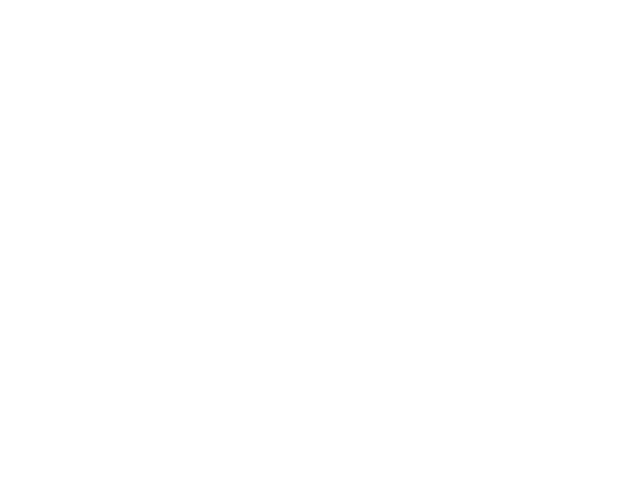

In [23]:
p.savefig(f"{DATASET_NAME}_blockaverage_parcels.png")

In [24]:
head_icbm152.brain

TrimeshSurface(faces: 29978 vertices: 15002 crs: ijk units: dimensionless vertex_coords: ['parcel'])

In [25]:
vertex_parcels = head_icbm152.brain.vertex_coords['parcel']
vertex_parcels = np.array(vertex_parcels)

parcel_index = blockaverage_10.get_index("parcel")  # pandas index
vertex_parcel_idx = parcel_index.get_indexer(vertex_parcels)

parcel_data = blockaverage_10.values  # shape (2, 107, 601, 2)

# Broadcast using integer indexing on axis=2 (parcel axis)
vertex_activity = parcel_data[:, :, vertex_parcel_idx, :]

n_vertices = len(vertex_parcel_idx)

vertex_da = xr.DataArray(
    vertex_activity,
    dims=("trial_type", "reltime", "vertex", "chromo"),
    coords=dict(
        trial_type=blockaverage_10.trial_type,
        reltime=blockaverage_10.reltime,
        chromo=blockaverage_10.chromo,

        # vertex index
        vertex=np.arange(n_vertices),

        # parcel label of each vertex
        parcel_of_vertex=("vertex", vertex_parcels),

        # NEW: is_brain flag
        is_brain=("vertex", np.ones(n_vertices, dtype=bool))
    )
)



In [26]:
vertex_da

<xarray.DataArray (trial_type: 2, reltime: 73, vertex: 15002, chromo: 2)> Size: 35MB
array([[[[-3.41610813e-07, -2.07470372e-08],
         [-3.41610813e-07, -2.07470372e-08],
         [-5.30539868e-10,  3.51043089e-10],
         ...,
         [ 3.50913832e-03, -2.01981242e-03],
         [-5.53253419e-04,  7.79332932e-04],
         [ 2.72038876e-03, -3.90843049e-03]],

        [[-1.16623895e-07,  2.65484512e-07],
         [-1.16623895e-07,  2.65484512e-07],
         [-7.33069784e-10,  1.25239499e-09],
         ...,
         [ 4.85637034e-03, -2.88510587e-03],
         [-2.44444967e-04,  1.85347397e-04],
         [-1.29461392e-03,  6.67327460e-04]],

        [[ 3.92092697e-07, -2.29463923e-07],
         [ 3.92092697e-07, -2.29463923e-07],
         [-4.14132792e-10,  8.36176528e-10],
         ...,
...
         ...,
         [ 1.26777729e-03,  1.95965799e-03],
         [-4.24081668e-04,  3.85881267e-04],
         [-1.15955940e-03,  1.47776692e-03]],

        [[-3.01232484e-06,  6.46796053e-07],
         [-3.01232484e-06,  6.46796053e-07],
         [-3.25388132e-09,  1.81393698e-09],
         ...,
         [ 8.18331794e-04,  1.52817651e-03],
         [-2.65358695e-04,  6.61723704e-04],
         [ 7.17249659e-04,  3.62376122e-04]],

        [[-2.94034552e-06,  3.28454272e-07],
         [-2.94034552e-06,  3.28454272e-07],
         [-3.93315423e-09,  1.76737294e-09],
         ...,
         [ 1.10575792e-03,  7.99960655e-04],
         [-1.07244107e-03,  1.07992702e-03],
         [ 3.92572482e-05,  8.90127848e-04]]]], shape=(2, 73, 15002, 2))
Coordinates:
  * trial_type        (trial_type) object 16B 'left' 'right'
  * reltime           (reltime) float64 584B -2.016 -1.904 ... 5.936 6.048
  * chromo            (chromo) <U3 24B 'HbO' 'HbR'
  * vertex            (vertex) int64 120kB 0 1 2 3 4 ... 14998 14999 15000 15001
    parcel_of_vertex  (vertex) <U44 3MB 'VisCent_ExStr_11_LH' ... 'DorsAttnB_...
    is_brain          (vertex) bool 15kB True True True True ... True True True

In [27]:
files[13:14]

['/home/orabe/fNIRS_sparseToDense/datasets/raw/FreshMotor/sub-04/ses-left3s/nirs/sub-04_ses-left3s_task-FRESHMOTOR_nirs.snirf']

In [28]:
import cedalion.vis.anatomy
filename_multiview = f'{DATASET_NAME}_blockaverage_left_multiview'

# prepare data
X_ts = vertex_da.sel(trial_type="left").rename({"reltime": "time"})
X_ts = X_ts.transpose("vertex", "chromo", "time")

scl = np.percentile(np.abs(X_ts.sel(chromo='HbO')).pint.dequantify(), 99)
clim = (-scl,scl)

cedalion.vis.anatomy.image_recon_multi_view(
    X_ts,  # time series data; can be 2D (static) or 3D (dynamic)
    head_icbm152,
    cmap='jet',
    clim=clim,
    view_type='hbo_brain',
    title_str='HbO / µM',
    filename=filename_multiview,
    SAVE=True,
    time_range=(-2,10,0.5)*units.s,
    fps=4,
    geo3d_plot = None, #  geo3d_plot
    wdw_size = (1024, 768)
)

In [29]:
import cedalion.vis.anatomy
filename_multiview = 'Yuanyuan_blockaverage_left'

# prepare data
X_ts = vertex_da.sel(trial_type="left").rename({"reltime": "time"})
X_ts = X_ts.transpose("vertex", "chromo", "time")

scl = np.percentile(np.abs(X_ts.sel(chromo='HbO')).pint.dequantify(), 99)
clim = (-scl,scl)

cedalion.vis.anatomy.image_recon_multi_view(
    X_ts,  # time series data; can be 2D (static) or 3D (dynamic)
    head_icbm152,
    cmap='jet',
    clim=clim,
    view_type='hbo_brain',
    title_str='HbO / µM',
    filename=filename_multiview,
    SAVE=True,
    time_range=(-2,10,0.5)*units.s,
    fps=4,
    geo3d_plot = None, #  geo3d_plot
    wdw_size = (1024, 768)
)